In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.signal import argrelextrema

sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

horizons = [2,5,60,250,1000]

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Past_Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
# Define the number of days for Stochastic Oscillator calculation
osc_n = 14

# Calculate Stochastic Oscillator for each day
sto_osc_values = []
rsi_values = []
for i in range(len(sp500)):
    if i < osc_n - 1:
        sto_osc_values.append(None)  # Placeholder for the initial days where there's not enough data
        rsi_values.append(None)
    else:
        # Calculate Stochastic Oscillator using data from the past 14 days including the current day
        min_price = sp500["Low"].iloc[i - osc_n + 1:i + 1].min()
        max_price = sp500["High"].iloc[i - osc_n + 1:i + 1].max()
        current_close = sp500["Close"].iloc[i]
        sto_osc = ((current_close - min_price) / (max_price - min_price)) * 100
        sto_osc_values.append(sto_osc)

        # RSI
        # Calculate average gain and average loss over the past osc_n days
        gains = [(sp500["Close"].iloc[j] - sp500["Close"].iloc[j - 1]) for j in range(i - osc_n + 1, i + 1) if sp500["Close"].iloc[j] > sp500["Close"].iloc[j - 1]]
        losses = [-(sp500["Close"].iloc[j] - sp500["Close"].iloc[j - 1]) for j in range(i - osc_n + 1, i + 1) if sp500["Close"].iloc[j] < sp500["Close"].iloc[j - 1]]
        
        # Calculate average gain and average loss considering only positive gains and losses
        avg_gain = sum(gains) / osc_n if gains else 0
        avg_loss = sum(losses) / osc_n if losses else 0
        
        # Calculate relative strength (RS)
        rs = avg_gain / avg_loss if avg_loss != 0 else float("inf")
        
        # Calculate RSI
        rsi = 100 - (100 / (1 + rs))
        rsi_values.append(rsi)

# Add Stochastic Oscillator values to DataFrame as a new column
sp500["Stochastic Oscillator"] = sto_osc_values
# Add RSI values to DataFrame as a new column
sp500["RSI"] = rsi_values

# Identifying Trends
order_parameters = [2, 7, 12]

for order in order_parameters:
    # Find local minima and maxima
    minima_indices = argrelextrema(sp500['Close'].values, np.less, order=order)[0]
    maxima_indices = argrelextrema(sp500['Close'].values, np.greater, order=order)[0]

    # Reset index
    sp500_copy = sp500.reset_index()

    # Create a new column for the current order parameter
    trend_column_name = f'Trend_Reversal_{order * 2 + 1}'
    sp500_copy[trend_column_name] = np.nan

    # Assign trend values based on local minima and maxima
    sp500_copy.loc[minima_indices, trend_column_name] = 0  # Downward trend
    sp500_copy.loc[maxima_indices, trend_column_name] = 1  # Upward trend

    # Set index back to original
    sp500_copy.set_index('Date', inplace=True)
    sp500[trend_column_name] = sp500_copy[trend_column_name]

# Fill NaN values with the previous valid value (i.e., forward fill)
sp500 = sp500.ffill()

# Adding News Sentiments
file_path = '~/OneDrive/Documents/Northeastern/CS 5100/CS5100 Final Project/data/sentiments/general_scores.csv'
df = pd.read_csv(file_path)
del df['Avg_Polarity']
del df['Avg_Subjectivity']

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

sp500_copy = sp500.copy()
sp500_copy.reset_index(inplace=True)
sp500_copy['Date'] = sp500_copy['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
merged_data = pd.merge(sp500_copy, df, on='Date', how='outer')
merged_data.set_index('Date', inplace=True)
merged_data = merged_data.dropna()

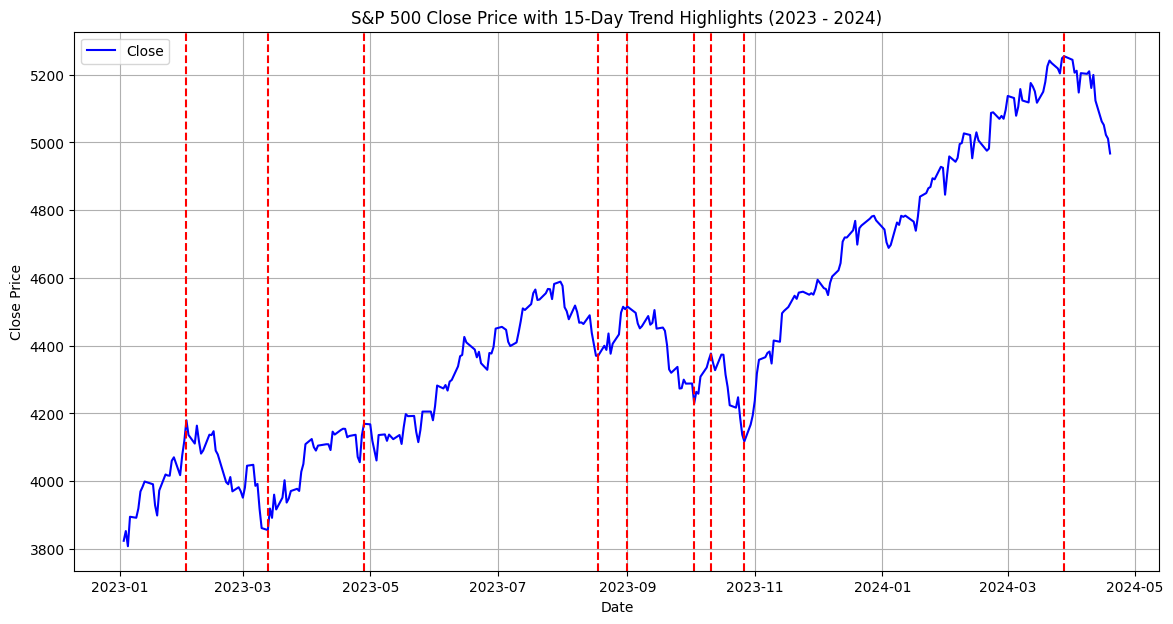

In [2]:
import matplotlib.pyplot as plt

# Filter the DataFrame for dates between 2023 and 2024
sp500_subset = sp500.loc['2023':'2024']

# Plot the Close column
plt.figure(figsize=(14, 7))
plt.plot(sp500_subset.index, sp500_subset['Close'], label='Close', color='blue')

# Highlight dates when Trend_9 transitions from 0 to 1 or 1 to 0
for i in range(1, len(sp500_subset)):
    if sp500_subset['Trend_Reversal_25'].iloc[i] != sp500_subset['Trend_Reversal_25'].iloc[i - 1]:
        plt.axvline(x=sp500_subset.index[i], color='red', linestyle='--')

plt.title('S&P 500 Close Price with 15-Day Trend Highlights (2023 - 2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
merged_data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Past_Trend_2,Close_Ratio_5,...,Close_Ratio_1000,Past_Trend_1000,Stochastic Oscillator,RSI,Trend_Reversal_5,Trend_Reversal_15,Trend_Reversal_25,Avg_Pos_Score,Avg_Neu_Score,Avg_Neg_Score
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,3.733160e+09,2447.889893,0.0,1.000634,2.0,1.007304,...,1.072879,524.0,48.235264,36.791648,0.0,0.0,0.0,0.073750,0.848000,0.078250
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,3.858830e+09,2531.939941,1.0,0.987466,1.0,0.983931,...,1.046128,524.0,31.306158,30.747061,0.0,0.0,0.0,0.057667,0.906111,0.036222
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,4.234140e+09,2549.689941,1.0,1.016878,1.0,1.014200,...,1.081807,525.0,64.251749,40.297452,0.0,0.0,0.0,0.069222,0.833000,0.097889
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,4.133120e+09,2574.409912,1.0,1.003493,2.0,1.016104,...,1.089132,526.0,79.791797,45.654805,0.0,0.0,0.0,0.056111,0.815444,0.128556
2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,4.120060e+09,2584.959961,1.0,1.004824,2.0,1.020461,...,1.099431,526.0,95.442114,52.592657,0.0,0.0,0.0,0.040000,0.874100,0.085900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12,5171.509766,5175.029785,5107.939941,5123.410156,3.963220e+09,5061.819824,0.0,0.992671,1.0,0.989251,...,1.244487,532.0,9.859282,37.114073,1.0,1.0,1.0,0.122100,0.804000,0.074000
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,3.950210e+09,5051.410156,0.0,0.993953,0.0,0.982693,...,1.228850,532.0,4.402305,33.554188,1.0,1.0,1.0,0.090900,0.741500,0.167700
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,4.006200e+09,5022.209961,0.0,0.998971,0.0,0.986745,...,1.225664,531.0,5.146243,33.853278,1.0,1.0,1.0,0.088500,0.815500,0.095900


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

baseline_p = ["Open", "Close", "High", "Low", "Volume"]
moving_averages_p = ["Close_Ratio_2", "Close_Ratio_5", "Close_Ratio_60", "Close_Ratio_250", "Close_Ratio_1000"]
past_trends_p = ["Past_Trend_2", "Past_Trend_5", "Past_Trend_60", "Past_Trend_250", "Past_Trend_1000"]
oscillator_p = ["Stochastic Oscillator", "RSI"]
sentiment_p = ["Avg_Pos_Score", "Avg_Neu_Score", "Avg_Neg_Score"]

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [5]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [6]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [7]:
def backtest(data, model, predictors, start=300, step=80):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# baseline_p = ["Open", "Close", "High", "Low", "Volume"]
# moving_averages_p = ["Close_Ratio_2", "Close_Ratio_5", "Close_Ratio_60", "Close_Ratio_250", "Close_Ratio_1000"]
# past_trends_p = ["Past_Trend_2", "Past_Trend_5", "Past_Trend_60", "Past_Trend_250", "Past_Trend_1000"]
# oscillator_p = ["Stochastic Oscillator", "RSI"]
# sentiment_p = ["Avg_Pos_Score", "Avg_Neu_Score", "Avg_Neg_Score"]

model = RandomForestClassifier(n_estimators=900, min_samples_split=200, random_state=1)
predictions = backtest(merged_data, model, moving_averages_p + sentiment_p)

pres = precision_score(predictions["Target"], predictions["Predictions"])
recall = recall_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f"{pres}\n{recall}\n{f1}")

0.5390455531453362
0.9085923217550275
0.6766507828454731


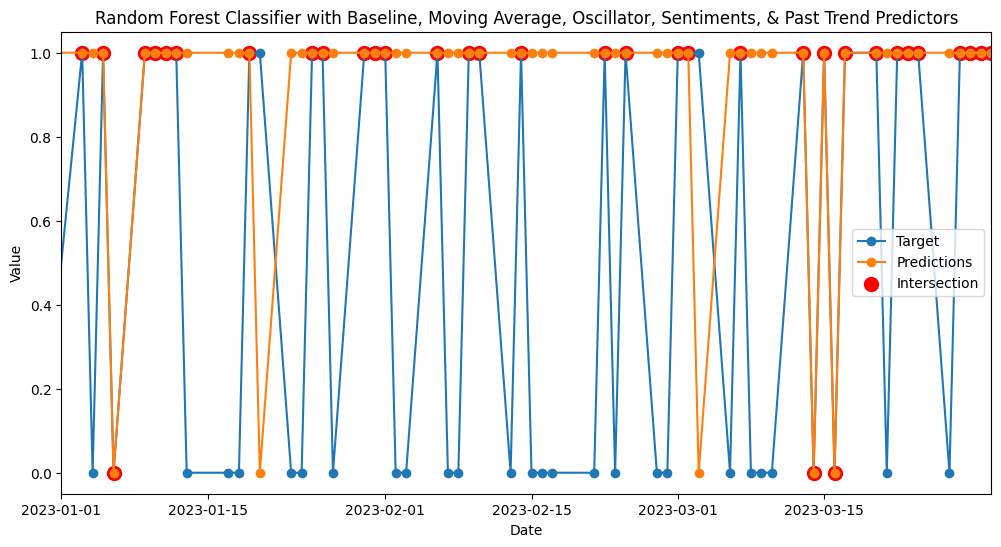

In [159]:
import matplotlib.pyplot as plt

# Assuming "Date" is the index column in your predictions DataFrame
predictions.index = pd.to_datetime(predictions.index)  # Convert the index to datetime if it's not already

# Filter the data for the year 2023
predictions_2023 = predictions[predictions.index.year == 2023]

# Plotting the Target and Predictions columns against the Date index
plt.figure(figsize=(12, 6))
plt.plot(predictions.index, predictions["Target"], label="Target", marker='o')
plt.plot(predictions.index, predictions["Predictions"], label="Predictions", marker='o')

# Marking where the two columns intersect
intersection_points = predictions[predictions["Target"] == predictions["Predictions"]]
plt.scatter(intersection_points.index, intersection_points["Target"], color='red', label='Intersection', s=100, marker='o')

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Random Forest Classifier with Baseline, Moving Average, Oscillator, Sentiments, & Past Trend Predictors")
plt.xlim(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-3-31"))  # Limit x-axis to year 2023
plt.legend()
plt.show()


In [148]:
predictions["Predictions"].value_counts()

Predictions
0.0    533
1.0    500
Name: count, dtype: int64

In [81]:
predictions["Target"].value_counts()

Target
1.0    547
0.0    486
Name: count, dtype: int64

In [160]:
# logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 1)

In [173]:
# baseline_p = ["Open", "Close", "High", "Low", "Volume"]
# moving_averages_p = ["Close_Ratio_2", "Close_Ratio_5", "Close_Ratio_60", "Close_Ratio_250", "Close_Ratio_1000"]
# past_trends_p = ["Past_Trend_2", "Past_Trend_5", "Past_Trend_60", "Past_Trend_250", "Past_Trend_1000"]
# oscillator_p = ["Stochastic Oscillator", "RSI"]
# sentiment_p = ["Avg_Pos_Score", "Avg_Neu_Score", "Avg_Neg_Score"]

def backtest(data, model, predictors, start=1067, step=266):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

predictions = backtest(merged_data, model, baseline_p)

pres = precision_score(predictions["Target"], predictions["Predictions"])
recall = recall_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f"{pres}\n{recall}\n{f1}")

0.5437262357414449
0.9930555555555556
0.7027027027027027


In [195]:
# baseline_p = ["Open", "Close", "High", "Low", "Volume"]
# moving_averages_p = ["Close_Ratio_2", "Close_Ratio_5", "Close_Ratio_60", "Close_Ratio_250", "Close_Ratio_1000"]
# past_trends_p = ["Past_Trend_2", "Past_Trend_5", "Past_Trend_60", "Past_Trend_250", "Past_Trend_1000"]
# oscillator_p = ["Stochastic Oscillator", "RSI"]
# sentiment_p = ["Avg_Pos_Score", "Avg_Neu_Score", "Avg_Neg_Score"]

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(merged_data[["Close"]], merged_data["Target"], test_size=0.2, random_state=1)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

pres = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
print(f"{pres}\n{recall}\n{f1}")

y_pred = pd.Series(y_pred, index=Y_test.index)

0.570281124497992
0.9403973509933775
0.71


<Axes: xlabel='Date'>

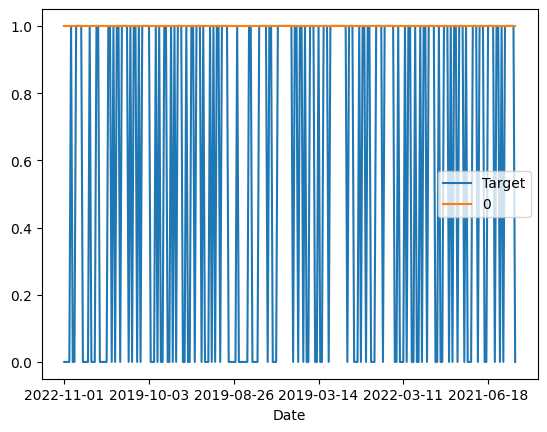

In [192]:
combined = pd.concat([Y_test, y_pred], axis=1)
combined.plot()